In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.models import Sequential,load_model, Model
from keras.layers import LSTM,Dense,Dropout,Activation,Input,Reshape, Lambda, RepeatVector
from keras.initializers import glorot_uniform
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras import backend as K
import keras
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
#Create a function to process the data into 1 day look back slices (for lstm model)
def processData(x, y, lb):
    X,Y = [],[]
    for i in range(len(x)-lb-1):
        X.append(x[i:(i+lb),:])
        Y.append(y[(i+lb),:])
    return np.array(X),np.array(Y)

# Output: (No. of Samples, Timesteps, No. of Features) 

In [3]:
class AccuracyHistory(keras.callbacks.Callback):
        def on_train_begin(self, logs={}):
            self.acc = []
        
        def on_epoch_end(self, batch, logs={}):
            self.acc.append(logs.get('acc'))

acc_history = AccuracyHistory()

In [4]:
def hardmax(test_pred):
    actual_predictions = []

    for i in range(len(test_pred)):
        if test_pred[i,0] > test_pred[i,1]:
            actual_predictions.append([0])
        else:
            actual_predictions.append([1])

    actual_predictions = np.array(actual_predictions)
    return actual_predictions

In [5]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black") # Original: color="white" if cm[i, j] > thresh else "black"

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Reading data into pandas dataframe

In [6]:
df = pd.read_csv('D:\\School\\Course Material\\Term 6\\50.038 - Computational Data Science\\Project files\\Dataframes\\final_eval2.csv')
df.shape

(6798, 10)

In [7]:
df.head()

,Date,price_change,Direction,ExVola50_Lag16,ExMomentum50_Lag16,ADF_Lag16,NormError_Lag16,Correlation_Lag16,ChevVola50_Lag16,ChevMomentum50_Lag16
0,1991-01-02,0.030457,1,-0.001316,-0.007561,0.025383,-2.088744,0.601761,-0.021620,-0.068910
1,1991-01-03,0.027704,1,0.005103,0.012759,0.028879,-2.004855,0.615327,-0.020591,-0.065876
2,1991-01-04,0.035176,1,0.001851,0.002515,0.067850,-1.284544,0.619378,-0.018410,-0.059425
3,1991-01-07,0.009926,1,0.006641,0.017681,0.016489,-1.027684,0.639093,-0.015645,-0.051195
4,1991-01-08,0.004950,1,0.006625,0.017628,0.005441,-0.255608,0.663768,-0.018472,-0.059628


In [12]:
# Selecting features from df dataframe to form numpy array: 

# Classification:
# df_filter = df[['ExVola50_Lag16','ExMomentum50_Lag16','Direction']]
df_filter = df[['ExVola50_Lag16','ExMomentum50_Lag16','ADF_Lag16', 'NormError_Lag16', 'Correlation_Lag16', 'ChevVola50_Lag16', 'ChevMomentum50_Lag16', 'Direction']]

# Regression:
# df_filter = df[['ExVola50_Lag16','ExMomentum50_Lag16','price_change']]
# df_filter = df[['ExVola50_Lag16','ExMomentum50_Lag16','ADF_Lag16', 'NormError_Lag16', 'Correlation_Lag16', 'ChevVola50_Lag16', 'ChevMomentum50_Lag16', 'price_change']]

df_filter.head()

,ExVola50_Lag16,ExMomentum50_Lag16,ADF_Lag16,NormError_Lag16,Correlation_Lag16,ChevVola50_Lag16,ChevMomentum50_Lag16,Direction
0,-0.001316,-0.007561,0.025383,-2.088744,0.601761,-0.021620,-0.068910,1
1,0.005103,0.012759,0.028879,-2.004855,0.615327,-0.020591,-0.065876,1
2,0.001851,0.002515,0.067850,-1.284544,0.619378,-0.018410,-0.059425,1
3,0.006641,0.017681,0.016489,-1.027684,0.639093,-0.015645,-0.051195,1
4,0.006625,0.017628,0.005441,-0.255608,0.663768,-0.018472,-0.059628,1


In [13]:
# Convert to numpy array
data = df_filter.values

print('Shape of data', data.shape)
print('First 5 rows of data',data[0:4,:])

Shape of data (6798, 8)
First 5 rows of data [[-1.31551870e-03 -7.56067482e-03  2.53829228e-02 -2.08874435e+00
   6.01760749e-01 -2.16202859e-02 -6.89100668e-02  1.00000000e+00]
 [ 5.10308837e-03  1.27591837e-02  2.88789511e-02 -2.00485539e+00
   6.15326854e-01 -2.05908157e-02 -6.58756757e-02  1.00000000e+00]
 [ 1.85061368e-03  2.51485133e-03  6.78498246e-02 -1.28454387e+00
   6.19378174e-01 -1.84095680e-02 -5.94253055e-02  1.00000000e+00]
 [ 6.64145949e-03  1.76808081e-02  1.64893921e-02 -1.02768414e+00
   6.39092978e-01 -1.56454385e-02 -5.11945392e-02  1.00000000e+00]]


In [14]:
# Splitting data array into feature and label array
label_num = 1 # How many labels are in the numpy array

X = data[:,:(data.shape[1] - label_num)]
y = data[:,(data.shape[1] - label_num):]

print('Feature array shape: ', X.shape)
print('Label array shape: ', y.shape)

Feature array shape:  (6798, 7)
Label array shape:  (6798, 1)


In [15]:
X_lstm, y_lstm = processData(X, y, 16)

print('Feature array shape: ', X_lstm.shape)
print('Label array shape: ', y_lstm.shape)

Feature array shape:  (6781, 16, 7)
Label array shape:  (6781, 1)


In [78]:
# # Reshape y_lstm array from 2D (x,1) to 1D (x,)
# y_lstm = y_lstm.reshape(-1)
# print('Label array shape: ', y_lstm.shape)

In [16]:
# train_proportion = 0.9

# X_train_lstm, X_test_lstm = X_lstm[:int(np.floor(X_lstm.shape[0]*train_proportion))],X_lstm[int(np.floor(X_lstm.shape[0]*train_proportion)):]
# y_train_lstm, y_test_lstm = y_lstm[:int(np.floor(y_lstm.shape[0]*train_proportion))],y_lstm[int(np.floor(y_lstm.shape[0]*train_proportion)):]

# print('Feature array shape (LSTM Training set): ', X_train_lstm.shape)
# print('Feature array shape (LSTM Test set): ', X_test_lstm.shape)
# print('Label array shape (LSTM Training set): ', y_train_lstm.shape)
# print('Label array shape (LSTM Test set): ', y_test_lstm.shape)

Feature array shape (LSTM Training set):  (6102, 16, 7)
Feature array shape (LSTM Test set):  (679, 16, 7)
Label array shape (LSTM Training set):  (6102, 1)
Label array shape (LSTM Test set):  (679, 1)


In [17]:
# # Convert class vectors to binary class matrices: For Classification

# y_train_lstm_class = to_categorical(y_train_lstm) # 2 classes
# y_test_lstm_class = to_categorical(y_test_lstm)

# print('Label array shape (LSTM Training set): ', y_train_lstm_class.shape)
# print('Label array shape (LSTM Dev set): ', y_test_lstm_class.shape)

Label array shape (LSTM Training set):  (6102, 2)
Label array shape (LSTM Dev set):  (679, 2)


In [12]:
# For Classification:
# early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=1, verbose=0, mode='auto', baseline=None)

# For Regression:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=1, verbose=1, mode='auto', baseline=None)

In [39]:
# fit an LSTM network to training data
def fit_lstm(X_train, y_train, batch_size, nb_epoch, neurons, mode = 'regression', validation = 0.1, earlyStop = True):
    # Configure learning parameters
    opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.01)
    
    # Define model
    model = Sequential()
    
    # LSTM layer input layer
#     model.add(LSTM(neurons, input_shape = (X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(neurons, input_shape = (X_train.shape[1], X_train.shape[2]), return_sequences = True))
#     model.add(Dropout(0.5))
    
    # Hidden layer: LSTM
    model.add(LSTM(neurons))
#     model.add(Dropout(0.5))
    
    # Output layer
    if mode == 'regression':
        model.add(Dense(1)) # For Regression
        model.compile(loss = 'mse', optimizer = opt, metrics=['mse']) # For Regression
        if earlyStop == True:
            history = model.fit(X_train, y_train, epochs = nb_epoch, batch_size = batch_size, verbose = 1, shuffle = False, 
                            validation_split = validation, callbacks = [early_stopping])
        else:
            history = model.fit(X_train, y_train, epochs = nb_epoch, batch_size = batch_size, verbose = 1, shuffle = False, 
                            validation_split = validation, callbacks = [acc_history])
    elif mode == 'classification':
        model.add(Dense(2, activation = 'softmax')) # For Classification
        model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics=['accuracy']) # For Classification
        if earlyStop == True:
            history = model.fit(X_train, y_train, epochs = nb_epoch, batch_size = batch_size, verbose = 1, shuffle = False, 
                            validation_split = validation, callbacks = [early_stopping])
        else: 
            history = model.fit(X_train, y_train, epochs = nb_epoch, batch_size = batch_size, verbose = 1, shuffle = False, 
                            validation_split = validation, callbacks = [acc_history])    
    
    return model, history

In [44]:
# Nested Cross Validation, k = 5:
def nested_cv(k, X, y, model_name, mode = "regression"):
    train_acc = []
    test_acc = []
    for i in range(k):
               
        x_train_cv, x_test_cv = X[:int(np.floor(X.shape[0]*((i+1)/(k+1))))],X[int(np.floor(X.shape[0]*((i+1)/(k+1)))):int(np.floor(X.shape[0]*((i+2)/(k+1))))]
        y_train_cv, y_test_cv = y[:int(np.floor(y.shape[0]*((i+1)/(k+1))))],y[int(np.floor(y.shape[0]*((i+1)/(k+1)))):int(np.floor(y.shape[0]*((i+2)/(k+1))))]
        if mode == "classification":
            y_train_class, y_test_cv = to_categorical(y_train_cv), to_categorical(y_test_cv)# 2 classes
            lstm_model, lstm_history = fit_lstm(x_train_cv, y_train_class, 32, 10, 256, mode = mode, 
                                                validation = 0.1, earlyStop = False)
            acc_history = lstm_history.history['acc']
            train_acc.append(acc_history[-1])
            test_result = lstm_model.evaluate(x = x_test_cv, y = y_test_cv, batch_size = None, verbose = 1)
            test_acc.append(test_result[1])
        elif mode == "regression":
            lstm_model, lstm_history = fit_lstm(x_train_cv, y_train_cv, 32, 100, 128, mode = mode, 
                                                validation = 0.1, earlyStop = False)
            mse_history = lstm_history.history['loss']
            train_acc.append(mse_history[-1])
            test_result = lstm_model.evaluate(x = x_test_cv, y = y_test_cv, batch_size = None, verbose = 1)
            test_acc.append(test_result[1])
            
        if i == k-1:
            lstm_model.save('./Saved_models/' + model_name)
            
    return train_acc, test_acc, lstm_model, lstm_history
            

In [51]:
train_acc, test_acc, model, history = nested_cv(5, X_lstm, y_lstm, 'sn_32.h5', mode = "regression")

Train on 1017 samples, validate on 113 samples
Epoch 1/100
1017/1017 [==============================] - 9s 8ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 2/100
1017/1017 [==============================] - 3s 3ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 3/100
1017/1017 [==============================] - 3s 3ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 4/100
1017/1017 [==============================] - 3s 3ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 5/100
1017/1017 [==============================] - 3s 3ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 6/100
1017/1017 [==============================] - 3s 3ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0

Epoch 48/100
1017/1017 [==============================] - 3s 3ms/step - loss: 9.1105e-04 - mean_squared_error: 9.1105e-04 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 49/100
1017/1017 [==============================] - 3s 3ms/step - loss: 9.1033e-04 - mean_squared_error: 9.1033e-04 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 50/100
1017/1017 [==============================] - 3s 3ms/step - loss: 9.0962e-04 - mean_squared_error: 9.0962e-04 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 51/100
1017/1017 [==============================] - 3s 3ms/step - loss: 9.0893e-04 - mean_squared_error: 9.0893e-04 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 52/100
1017/1017 [==============================] - 3s 3ms/step - loss: 9.0824e-04 - mean_squared_error: 9.0824e-04 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 53/100
1017/1017 [==============================] - 3s 3ms/step - loss: 9.0757e-04 - mean_squared_error: 9.0757e-04 - val_lo

2034/2034 [==============================] - 5s 3ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 44/100
2034/2034 [==============================] - 5s 3ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 45/100
2034/2034 [==============================] - 5s 3ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 46/100
2034/2034 [==============================] - 5s 3ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 47/100
2034/2034 [==============================] - 5s 3ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 48/100
2034/2034 [==============================] - 6s 3ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 49/100
2034

Epoch 41/100
3051/3051 [==============================] - 11s 4ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 42/100
3051/3051 [==============================] - 10s 3ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 43/100
3051/3051 [==============================] - 10s 3ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 44/100
3051/3051 [==============================] - 11s 4ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 45/100
3051/3051 [==============================] - 10s 3ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 46/100
3051/3051 [==============================] - 10s 3ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0014 - val_mean_squared_error: 0.001

Epoch 90/100
3051/3051 [==============================] - 8s 3ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 91/100
3051/3051 [==============================] - 11s 4ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 92/100
3051/3051 [==============================] - 10s 3ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 93/100
3051/3051 [==============================] - 9s 3ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 94/100
3051/3051 [==============================] - 10s 3ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 95/100
3051/3051 [==============================] - 10s 3ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0015 - val_mean_squared_error: 0.0015


4068/4068 [==============================] - 13s 3ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 88/100
4068/4068 [==============================] - 13s 3ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 89/100
4068/4068 [==============================] - 14s 3ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 90/100
4068/4068 [==============================] - 13s 3ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 91/100
4068/4068 [==============================] - 15s 4ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 92/100
4068/4068 [==============================] - 14s 3ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 93/10

5085/5085 [==============================] - 15s 3ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 85/100
5085/5085 [==============================] - 14s 3ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 86/100
5085/5085 [==============================] - 14s 3ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 87/100
5085/5085 [==============================] - 16s 3ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 88/100
5085/5085 [==============================] - 16s 3ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 89/100
5085/5085 [==============================] - 14s 3ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 90/10

In [52]:
print('Training Accuracy:',train_acc)
print('Test Accuracy:',test_acc)
print('Mean of Training Accuracy/MSE:', np.mean(train_acc))
print('Mean of Test Accuracy/MSE:', np.mean(test_acc))

Training Accuracy: [0.0008828586516359266, 0.0011304118700285195, 0.001744834737265675, 0.0018247723042087642, 0.002058514900209754]
Test Accuracy: [0.00216995379619663, 0.0027153562554529153, 0.0029151415485328277, 0.0022722053911281436, 0.0016827589726124113]
Mean of Training Accuracy/MSE: 0.0015282784926697278
Mean of Test Accuracy/MSE: 0.0023510831927845855


In [ ]:
# model_name = 'sn_33.h5'

# # For Classification:
# lstm_model, lstm_history = fit_lstm(X_train_lstm, y_train_lstm_class, 32, 10, 64,model_name, 
#                                     mode = "classification", validation = 0.1, earlyStop = False)
## For Regression:
# lstm_model, lstm_history = fit_lstm(X_train_lstm, y_train_lstm, 32, 500, 1024, model_name, 
#                                     mode = "regression", validation = 0.1, earlyStop = True)

Train on 4309 samples, validate on 479 samples
Epoch 1/500
4309/4309 [==============================] - 25s 6ms/step - loss: 19.0258 - mean_absolute_percentage_error: 19.0258 - val_loss: 43.0888 - val_mean_absolute_percentage_error: 43.0888
Epoch 2/500
4309/4309 [==============================] - 17s 4ms/step - loss: 19.5323 - mean_absolute_percentage_error: 19.5323 - val_loss: 40.9388 - val_mean_absolute_percentage_error: 40.9388
Epoch 3/500
4309/4309 [==============================] - 17s 4ms/step - loss: 17.2218 - mean_absolute_percentage_error: 17.2218 - val_loss: 38.2213 - val_mean_absolute_percentage_error: 38.2213
Epoch 4/500
4309/4309 [==============================] - 18s 4ms/step - loss: 17.5446 - mean_absolute_percentage_error: 17.5446 - val_loss: 36.4673 - val_mean_absolute_percentage_error: 36.4673
Epoch 5/500
4309/4309 [==============================] - 17s 4ms/step - loss: 16.2317 - mean_absolute_percentage_error: 16.2317 - val_loss: 34.9611 - val_mean_absolute_percentag

# Plotting of Graphs

Text(0,0.5,'Loss value')

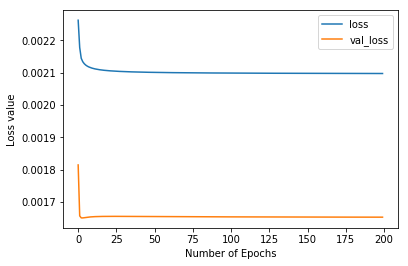

In [55]:
# Plotting Training and Validation Loss
model_history = history

plt.plot(model_history.history['loss'], label = 'loss')
plt.plot(model_history.history['val_loss'], label = 'val_loss')
plt.legend()

plt.xlabel("Number of Epochs", fontsize = 10)
plt.ylabel("Loss value", fontsize = 10)
# plt.savefig('./Data_Visualisation/' + model_name + '-Loss_graph.png')

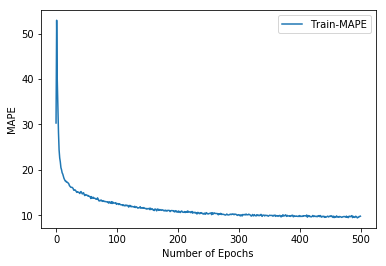

In [20]:
# Plotting Training and Validation Loss
model_history = history

plt.plot(model_history.history['mean_absolute_percentage_error'], label = 'Train-MAPE')
plt.plot(model_history.history['val_mean_absolute_percentage_error'], label = 'Val-MAPE')
plt.legend()

plt.xlabel("Number of Epochs", fontsize = 10)
plt.ylabel("MAPE", fontsize = 10)
# plt.savefig('./Data_Visualisation/' + model_name + '-Loss_graph.png')

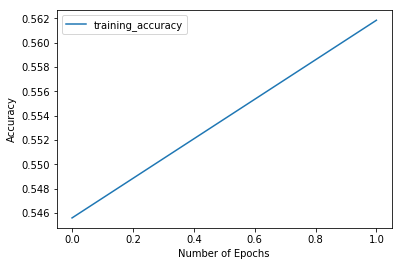

In [70]:
# Plotting Training and Validation accuracy
model_history = lstm_history

plt.plot(model_history.history['acc'], label = 'training_accuracy')
# plt.plot(model_history.history['val_acc'], label = 'validation_accuracy')
plt.legend()

plt.xlabel("Number of Epochs", fontsize = 10)
plt.ylabel("Accuracy", fontsize = 10)
plt.savefig('./Data_Visualisation/' + model_name + '-Acc_graph.png')

# Plotting the predicted price (Regression)

In [59]:
exxon = pd.read_csv('D:\\School\\Course Material\\Term 6\\50.038 - Computational Data Science\\Project files\\Dataframes\\final_eval2_v2.csv',index_col="Date",parse_dates = True)
exxon.head()

,price_change,Direction,ExVola50_Lag16,ExMomentum50_Lag16,ADF_Lag16,NormError_Lag16,Correlation_Lag16,ChevVola50_Lag16,ChevMomentum50_Lag16,ExClose_Lag16,ChevClose_Lag16
Date,,,,,,,,,,,
1991-01-02,0.030457,1,-0.001316,-0.007561,0.025383,-2.088744,0.601761,-0.021620,-0.068910,12.3125,17.3125
1991-01-03,0.027704,1,0.005103,0.012759,0.028879,-2.004855,0.615327,-0.020591,-0.065876,12.4063,17.2813
1991-01-04,0.035176,1,0.001851,0.002515,0.067850,-1.284544,0.619378,-0.018410,-0.059425,12.4375,17.3125
1991-01-07,0.009926,1,0.006641,0.017681,0.016489,-1.027684,0.639093,-0.015645,-0.051195,12.5938,17.3750
1991-01-08,0.004950,1,0.006625,0.017628,0.005441,-0.255608,0.663768,-0.018472,-0.059628,12.6250,17.2500


In [80]:
exxon_filter = exxon[['ExClose_Lag16']].loc['2012-8-27':'2017-11-28'].copy()
exxon_filter.shape

(1323, 1)

In [81]:
test = pd.read_csv('D:\\School\\Course Material\\Term 6\\50.038 - Computational Data Science\\Project files\\Dataframes\\final_eval2.csv',index_col="Date",parse_dates = True)
test.head()

,price_change,Direction,ExVola50_Lag16,ExMomentum50_Lag16,ADF_Lag16,NormError_Lag16,Correlation_Lag16,ChevVola50_Lag16,ChevMomentum50_Lag16
Date,,,,,,,,,
1991-01-02,0.030457,1,-0.001316,-0.007561,0.025383,-2.088744,0.601761,-0.021620,-0.068910
1991-01-03,0.027704,1,0.005103,0.012759,0.028879,-2.004855,0.615327,-0.020591,-0.065876
1991-01-04,0.035176,1,0.001851,0.002515,0.067850,-1.284544,0.619378,-0.018410,-0.059425
1991-01-07,0.009926,1,0.006641,0.017681,0.016489,-1.027684,0.639093,-0.015645,-0.051195
1991-01-08,0.004950,1,0.006625,0.017628,0.005441,-0.255608,0.663768,-0.018472,-0.059628


In [116]:
# Regression:
df_filter_plot = test[['ExVola50_Lag16','ExMomentum50_Lag16','price_change']].loc['2012-8-27':].copy()
# df_filter_plot = test[['ExVola50_Lag16','ExMomentum50_Lag16','ADF_Lag16', 'NormError_Lag16', 'Correlation_Lag16', 'ChevVola50_Lag16', 'ChevMomentum50_Lag16', 'price_change']].loc['2012-8-27':].copy()


In [117]:
data_plot = df_filter_plot.values
# Splitting data array into feature and label array
label_num = 1 # How many labels are in the numpy array

X_plot = data_plot[:,:(data_plot.shape[1] - label_num)]
y_plot = data_plot[:,(data_plot.shape[1] - label_num):]

In [118]:
X_lstm_plot, y_lstm_plot = processData(X_plot, y_plot, 16)

In [119]:
model_name = 'sn_29.h5'
test_model = load_model('./Saved_models/' + model_name)
test_predictions_plot = test_model.predict(X_lstm_plot, batch_size=None, verbose = 1)
print(test_predictions_plot)

1323/1323 [==============================] - 4s 3ms/step
[[0.00387264]
 [0.00496725]
 [0.0048581 ]
 ...
 [0.00739812]
 [0.00722139]
 [0.00734082]]


In [120]:
exxon_filter['pred'] = test_predictions_plot
exxon_filter['pred_price'] = (exxon_filter['pred']+1)*exxon_filter['ExClose_Lag16']

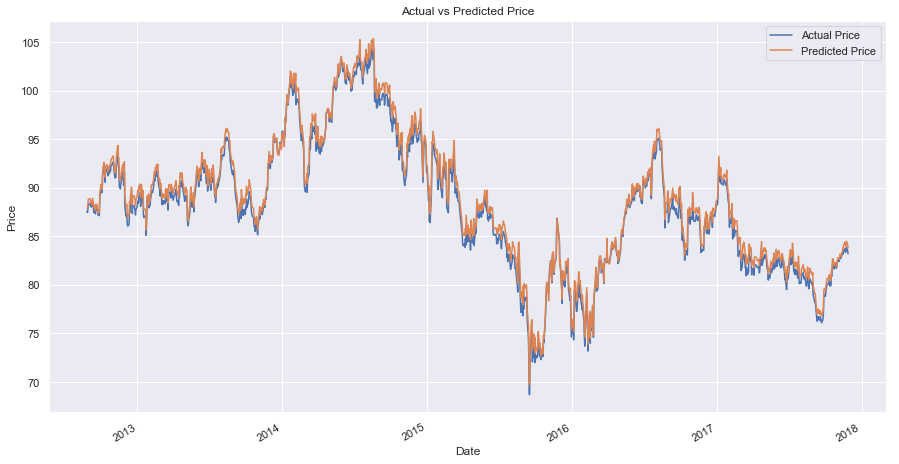

In [121]:
# Plotting for Regression only
import seaborn as sns
from matplotlib.pyplot import *
sns.set()

fig, ax = subplots()
exxon_filter[['ExClose_Lag16','pred_price']].plot(title= 'Actual vs Predicted Price',figsize = (15,8), ax=ax)
ax.legend(["Actual Price", "Predicted Price"]);
plt.ylabel('Price')
plt.savefig('./Data_Visualisation/' + model_name + '-Pred_price_graph.png')

# Testing Model

In [152]:
test = pd.read_csv('D:\\School\\Course Material\\Term 6\\50.038 - Computational Data Science\\Project files\\test_final.csv')
test.shape

(2013, 9)

In [153]:
# For Classification:
test_filter = test[['ExCloseLag13','BetaLag13','Norm_ErrorLag13','ADFLag13','CorrelationLag13','ExMomentum100','Direction']]

# For Regression:
# test_filter = test[['ExCloseLag13','BetaLag13','Norm_ErrorLag13','ADFLag13','CorrelationLag13','ExMomentum100','ExClose']]

test_filter.shape

(2013, 7)

In [154]:
# Convert to numpy array
Xy = test_filter.values
Xy.shape

(2013, 7)

In [155]:
# Splitting data array into feature and label array
X_test_array = Xy[:,:6]
y_test_array = Xy[:,6:]

print('Feature array shape: ', X_test_array.shape)
print('Label array shape: ', y_test_array.shape)

Feature array shape:  (2013, 6)
Label array shape:  (2013, 1)


In [156]:
X_test_array_lstm, y_test_array_lstm = processData(X_test_array, y_test_array, 1)
print(X_test_array_lstm.shape)
print(y_test_array_lstm.shape)

(2011, 1, 6)
(2011, 1)


In [159]:
# Convert class vectors to binary class matrices: For Classification

y_test_array_lstm = to_categorical(y_test_array_lstm, num_classes = 2) # 2 classes: 0,1

print(y_test_array_lstm.shape)

(2011, 2)
(2013, 2)


# Loading Model

In [201]:
model_name = 'sn_31.h5'
test_model = load_model('./Saved_models/' + model_name)

In [202]:
# Returns the loss value & metrics values for the model in test model
print(test_model.metrics_names)

test_model.evaluate(x = X_test_array_lstm, y = y_test_array_lstm, batch_size = None, verbose = 1)

['loss', 'acc']
2013/2013 [==============================] - 2s 1ms/step


[0.6890138054569148, 0.5484351712971615]

In [203]:
# For LSTM model:
test_predictions = test_model.predict(X_test_array_lstm, batch_size=None, verbose = 1)

print(test_predictions)

2013/2013 [==============================] - 2s 984us/step
[[0.44 0.56]
 [0.45 0.55]
 [0.44 0.56]
 ...
 [0.44 0.56]
 [0.44 0.56]
 [0.44 0.56]]


Text(0,0.5,'Price')

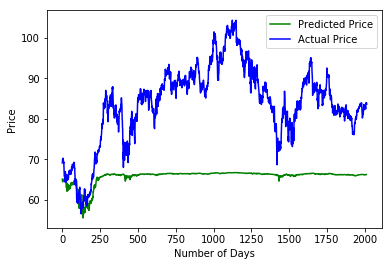

In [92]:
# Plotting for Regression only

plt.plot(test_predictions,color='green', label = 'Predicted Price')
plt.plot(y_test_array, color = 'blue', label = 'Actual Price')
plt.legend()
plt.xlabel("Number of Days", fontsize = 10)
plt.ylabel("Price", fontsize = 10)

In [204]:
# For classification only

actual_predictions = hardmax(test_predictions)
print('Actual Predictions Shape Array:', actual_predictions.shape)

# Reverse to_categorical():

y_test_labels = np.argmax(y_test_array_lstm, axis = 1)
y_test_labels = y_test_labels.reshape(y_test_labels.shape[0],-1)

print('y_test_labels shape Array', y_test_labels.shape)

Actual Predictions Shape Array: (2013, 1)
y_test_labels shape Array (2013, 1)


In [180]:
# Plot confusion matrix
class_names = np.array(['0','1']) # Numpy array size: (2,)

print(class_names.shape) 

(2,)


Confusion matrix, without normalization
[[   0  909]
 [   0 1104]]
Normalized confusion matrix
[[0. 1.]
 [0. 1.]]


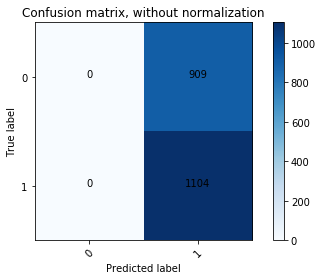

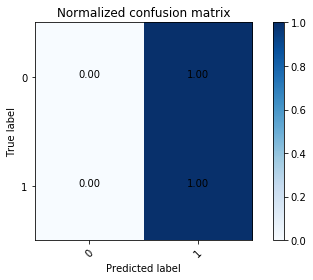

In [205]:
# Compute confusion matrix

# confusion_matrix(actual label array, prediction array)
cnf_matrix = confusion_matrix(y_test_labels, actual_predictions)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')
# plt.savefig('./Data_Visualisation/' + model_name + '-Confusion_matrix.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
# plt.savefig('./Data_Visualisation/' + model_name + '-Confusion_matrix_normalised.png')

plt.show()

In [206]:
# Compute recall (tp / (tp + fn), precision (tp / (tp + fp)) and F1-score
# Precision: Measure of classifier ability of not labelling a sample that is negative as positive 
# Recall: Measure of classifier ability to find all the positive samples

precision_recall_fscore_support(y_test_labels, actual_predictions, average='binary') 
# Output: (precision, recall, fbeta_score, support)

(0.5484351713859911, 1.0, 0.7083734359961501, None)